In [1]:
from scipy.signal import hamming
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile
import pandas as pd
from  scikits.talkbox import lpc
from mpl_toolkits.mplot3d import Axes3D
import dtw
from  sklearn.decomposition import NMF
from sklearn.preprocessing import  minmax_scale
from scipy.spatial.distance import mahalanobis,cdist,euclidean
from sklearn.metrics import pairwise_distances

In [2]:
sample_rate, signal = scipy.io.wavfile.read('subset/-2qsCrkXdWs.001.wav')  # File assumed to be in the same directory

frame_size = 0.025 #25 ms 
frame_stride=0.01 #15 ms overlap
signal_length = len(signal)

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

In [3]:


num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

### Hamming window function

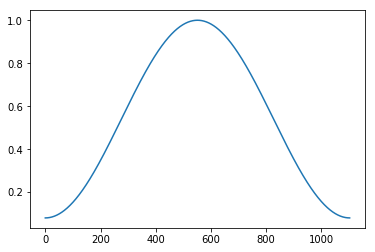

In [4]:
windows=np.hamming(frame_length)
frames *= windows
plt.plot(windows)
plt.show()

### Frames in time domain

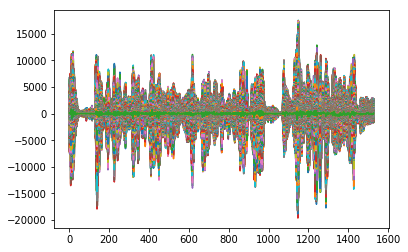

In [5]:
plt.plot(frames)
plt.show()

### Frames in frequency domain (FFT)

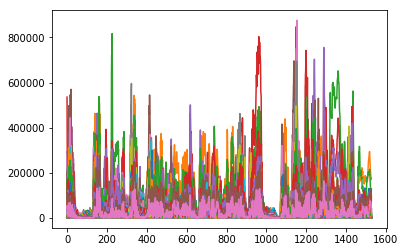

In [6]:
NFFT=512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT

pow_frames = ( (10*np.log10(mag_frames) ))  # Power Spectrum
plt.plot(mag_frames)

plt.show()

### Spectogram

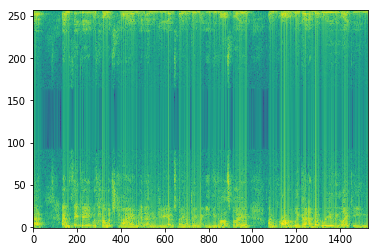

In [7]:
plt.clf()
plt.imshow(pow_frames.T,aspect="auto")
plt.gca().invert_yaxis()
plt.show()

### LP Coefficients 

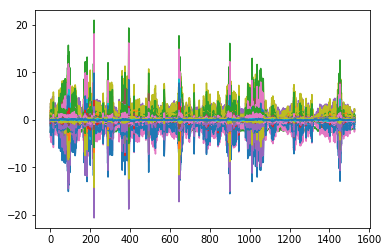

In [8]:
plt.plot(lpc(frames,30)[0])
plt.show()


In [9]:
def extract_frames(signal,sample_rate):
    signal_length = len(signal)

    
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    windows=np.hamming(frame_length)
    frames *= windows
    return frames


df=pd.read_csv("subset/labels.csv",sep="\t",dtype=object)
df=df[0:50]
distance_matrix=np.zeros((len(df),len(df)))

df["rate"]=0
signals=[]
frames=[]
lpcs_inversion=[]
lpcs_errors=[]
lpcs_coefs=[]
for idx,row in df.iterrows():
    rate,signal=scipy.io.wavfile.read('subset/'+row[1])  # File assumed to be in the same directory)


    df.loc[idx,"rate"]=rate
    signals.append(signal)
    extracted_frame=extract_frames(signal,rate)
    frames.append(extracted_frame)
    a,e,k=lpc(extracted_frame,30)

    lpcs_inversion.append(a)
    lpcs_errors.append(e)
    lpcs_coefs.append(k)
df["signal"]=signals
df["frame"]=frames
df["lpc_inversion"]=lpcs_inversion
df["lpc_errors"]=lpcs_errors
df["lpc_coefs"]=lpcs_coefs


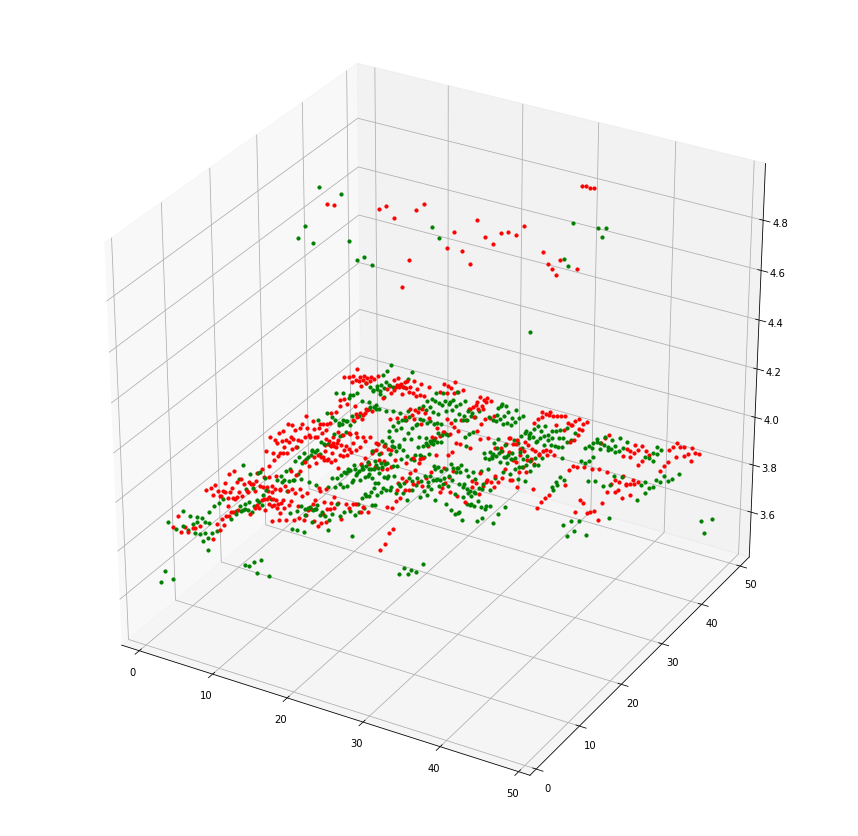

In [10]:
fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for i in range(1,len(distance_matrix)-1):
    for j in range(i+1,len(distance_matrix)):
        error=dtw.fastdtw(lpcs_coefs[i],lpcs_coefs[j],'mahalanobis')[0]

        distance_matrix[i][j]=error
        color='r'
        if df.loc[i,"Gender"]==df.loc[j,"Gender"]:
            color="g"
        ax.scatter(i,j,error,s=10,c=color)
plt.show()

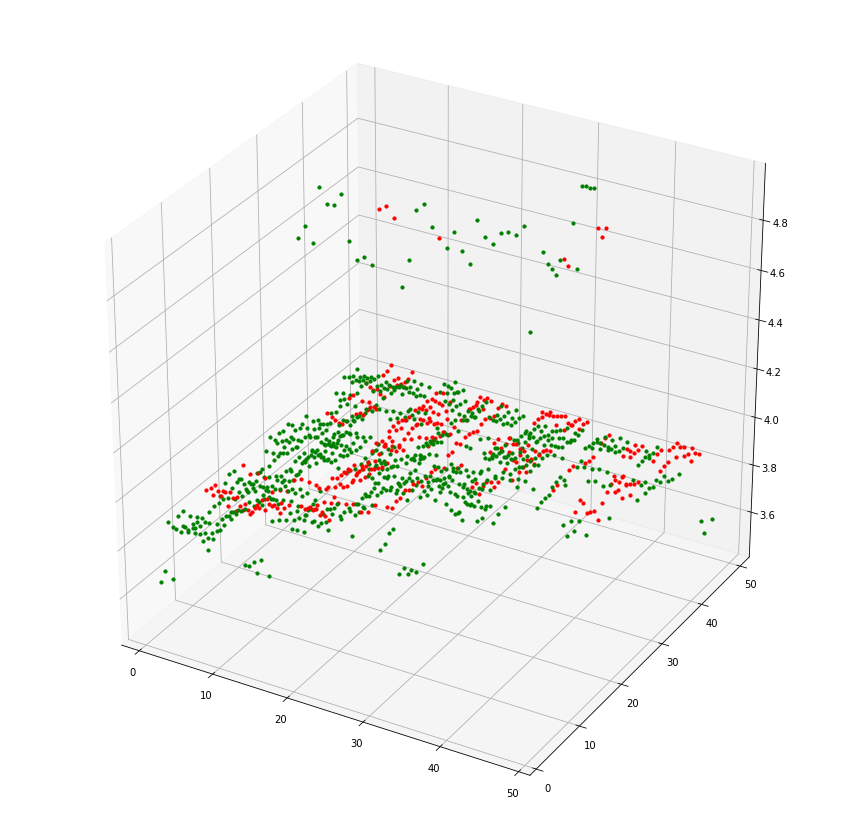

In [11]:
fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for i in range(1,len(distance_matrix)-1):
    for j in range(i+1,len(distance_matrix)):
        error=distance_matrix[i][j]
        color='r'
        if df.loc[i,"Ethnicity"]==df.loc[j,"Ethnicity"]:
            color="g"
        ax.scatter(i,j,error,s=10,c=color)
plt.show()